<a href="https://colab.research.google.com/github/rohithkandula/NLP-Coursework-WASSA2023-Empathy/blob/main/NLPCW1_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# =========================
from google.colab import files
uploaded = files.upload()
uploaded

import pandas as pd
import os

# Find the train TSV you uploaded
train_tsv = None
for f in os.listdir("/content"):
    low = f.lower()
    if ("with_labels" in low) or ("train" in low and f.endswith(".tsv")):
        train_tsv = f
        break

if train_tsv is None:
    raise FileNotFoundError("No TRAIN TSV found. Upload the correct TSV.")

print("Using TRAIN TSV:", train_tsv)

df = pd.read_csv("/content/" + train_tsv, sep="\t")

# We use 'Empathy' as the gold label (your project uses single-label regression)
if "Empathy" not in df.columns:
    raise ValueError("Label column 'Empathy' not found. Check file columns.")

df2 = df[["text", "Empathy"]].rename(columns={"Empathy": "label"})
df2 = df2.dropna(subset=["text", "label"])
df2.to_csv("/content/wassa_conv_train_all.csv", index=False)

print("Saved cleaned CSV to /content/wassa_conv_train_all.csv")
print("Rows:", df2.shape[0])
df2.head()

# One-cell: Generate all code artifacts for the REPORT
# - Requires /content/wassa_conv_train_all.csv present
# - Produces: CV matrix CSV, per-fold predictions, plots, top features, error analysis,
#   markdown results paragraph and a markdown table for report
# =========================

# Install (quiet)
!pip -q install pandas==2.2.2 scikit-learn==1.6.1 matplotlib==3.9.2 joblib==1.4.2 || true

# Imports & config
import os, re, unicodedata, json, math, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import stats, sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import LinearSVR
from sklearn.linear_model import Ridge

warnings.filterwarnings("ignore")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_CSV = "/content/wassa_conv_train_all.csv"
OUT_DIR = "/content/report_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

# Early check
if not os.path.exists(DATA_CSV):
    raise FileNotFoundError(f"{DATA_CSV} not found. Upload or build the CSV first.")

# -----------------------
# Load data
# -----------------------
df = pd.read_csv(DATA_CSV)
if not {"text","label"}.issubset(df.columns):
    raise AssertionError("CSV must contain 'text' and 'label' columns.")
df = df.dropna(subset=["text","label"]).copy()
df["y"] = df["label"].astype(float)
X_all = df["text"].tolist()
y_all = df["y"].tolist()
print(f"Loaded {len(df)} rows. Label range: [{min(y_all)}, {max(y_all)}]")

# -----------------------
# Cleaning & affect features (picklable)
# -----------------------
EMOJI_PATTERN   = re.compile("[" "\U0001F600-\U0001F64F" "\U0001F300-\U0001F5FF" "\U0001F680-\U0001F6FF" "\U0001F1E0-\U0001F1FF" "]+")
URL_PATTERN     = re.compile(r"(https?://\S+|www\.\S+)")
MENTION_PATTERN = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#\w+")
ELONG_PATTERN   = re.compile(r"(.)\1{2,}")

def basic_clean(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.strip().lower()
    s = URL_PATTERN.sub(" <URL> ", s)
    s = MENTION_PATTERN.sub(" <USER> ", s)
    s = HASHTAG_PATTERN.sub(" <HASHTAG> ", s)
    s = ELONG_PATTERN.sub(r"\1\1\1", s)
    s = unicodedata.normalize("NFKC", s)
    return s

def clean_batch(X):
    return [basic_clean(t) for t in X]

class AffectFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        rows=[]
        for t in X:
            t = t if isinstance(t,str) else ""
            ex = t.count("!")
            qn = t.count("?")
            toks = t.split()
            caps = sum(1 for w in toks if w.isupper() and len(w)>1)
            allcaps = caps / max(1, len(toks))
            emoji = len(EMOJI_PATTERN.findall(t))
            ell = t.count("...")
            elong = sum(1 for w in toks if ELONG_PATTERN.search(w))
            rows.append([ex, qn, allcaps, emoji, ell, elong])
        A = np.array(rows, dtype=float)
        return sparse.csr_matrix((A - A.mean(axis=0)) / (A.std(axis=0) + 1e-8))

# -----------------------
# Feature union and pipeline builder
# -----------------------
feats = FeatureUnion([
    ("word_tfidf", TfidfVectorizer(analyzer="word", ngram_range=(1,2), min_df=2,
                                   max_features=40000, lowercase=False,
                                   token_pattern=r"(?u)\b\w+\b|<URL>|<USER>|<HASHTAG>")),
    ("char_tfidf", TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=2,
                                   max_features=50000, lowercase=False)),
    ("affect", AffectFeatures())
])

def build_pipe(reg):
    return Pipeline([
        ("clean", FunctionTransformer(clean_batch, validate=False)),
        ("featurizer", feats),
        ("reg", reg)
    ])

# -----------------------
# Models (use your tuned params)
# -----------------------
models = {
    "Ridge": Ridge(alpha=2.0, random_state=RANDOM_SEED),
    "LinearSVR": LinearSVR(C=0.5, epsilon=0.2, random_state=RANDOM_SEED, max_iter=10000)
}

# -----------------------
# Run 5-fold CV and collect per-fold preds
# -----------------------
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

summary_records = []
per_model_preds = {}  # to collect concatenated cv preds for plotting/analysis

for name, reg in models.items():
    print(f"\n>>> Evaluating {name}")
    fold_rows = []
    preds_concat = []
    for fold_id, (tr_idx, va_idx) in enumerate(kf.split(X_all), start=1):
        X_tr = [X_all[i] for i in tr_idx]; y_tr = [y_all[i] for i in tr_idx]
        X_va = [X_all[i] for i in va_idx]; y_va = [y_all[i] for i in va_idx]

        pipe = build_pipe(reg)
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_va)

        mae = mean_absolute_error(y_va, y_pred)
        rmse = math.sqrt(mean_squared_error(y_va, y_pred))
        pear = float(stats.pearsonr(y_va, y_pred)[0]) if len(set(y_va))>1 else 0.0
        r2 = r2_score(y_va, y_pred)

        fold_rows.append({"fold":fold_id,"MAE":mae,"RMSE":rmse,"Pearson":pear,"R2":r2})
        print(f" Fold {fold_id}: MAE={mae:.4f}, RMSE={rmse:.4f}, r={pear:.4f}, R2={r2:.4f}")

        # save fold preds
        fold_df = pd.DataFrame({"text": X_va, "y_true": y_va, "y_pred": y_pred})
        fold_csv = os.path.join(OUT_DIR, f"{name}_fold{fold_id}_predictions.csv")
        fold_df.to_csv(fold_csv, index=False)
        preds_concat.append(fold_df)

    # aggregate
    folds_df = pd.DataFrame(fold_rows)
    folds_df.to_csv(os.path.join(OUT_DIR, f"{name}_folds_summary.csv"), index=False)

    mean_mae = folds_df["MAE"].mean(); std_mae = folds_df["MAE"].std(ddof=1)
    mean_rmse = folds_df["RMSE"].mean(); std_rmse = folds_df["RMSE"].std(ddof=1)
    mean_pear = folds_df["Pearson"].mean(); std_pear = folds_df["Pearson"].std(ddof=1)
    mean_r2 = folds_df["R2"].mean(); std_r2 = folds_df["R2"].std(ddof=1)

    summary_records.append({
        "Model": name,
        "MAE_mean": mean_mae, "MAE_std": std_mae,
        "RMSE_mean": mean_rmse, "RMSE_std": std_rmse,
        "Pearson_mean": mean_pear, "Pearson_std": std_pear,
        "R2_mean": mean_r2, "R2_std": std_r2
    })

    per_model_preds[name] = pd.concat(preds_concat, ignore_index=True)

# -----------------------
# Save matrix CSV + pretty markdown table + report paragraph
# -----------------------
summary_df = pd.DataFrame(summary_records).set_index("Model")
def fmt(m,s): return f"{m:.4f} ± {s:.4f}"
rows = []
for idx, row in summary_df.iterrows():
    rows.append({
        "Model": idx,
        "MAE (mean±std)": fmt(row["MAE_mean"], row["MAE_std"]),
        "RMSE (mean±std)": fmt(row["RMSE_mean"], row["RMSE_std"]),
        "Pearson r (mean±std)": fmt(row["Pearson_mean"], row["Pearson_std"]),
        "R2 (mean±std)": fmt(row["R2_mean"], row["R2_std"])
    })
matrix_df = pd.DataFrame(rows).set_index("Model")
matrix_csv = os.path.join(OUT_DIR, "models_cv_summary_matrix.csv")
matrix_df.to_csv(matrix_csv)
print("\nSaved summary matrix to:", matrix_csv)

# write markdown table for report
md_lines = []
md_lines.append("| Model | MAE (mean±std) | RMSE (mean±std) | Pearson r (mean±std) | R2 (mean±std) |")
md_lines.append("|---|---:|---:|---:|---:|")
for idx, row in matrix_df.iterrows():
    md_lines.append(f"| {idx} | {row['MAE (mean±std)']} | {row['RMSE (mean±std)']} | {row['Pearson r (mean±std)']} | {row['R2 (mean±std)']} |")
md_table = "\n".join(md_lines)
md_path = os.path.join(OUT_DIR, "report_metrics_table.md")
with open(md_path, "w") as f:
    f.write(md_table)
print("Saved markdown table to:", md_path)

# write ready-to-paste results paragraph (numbers embedded)
# choose best model by MAE_mean
best_idx = summary_df["MAE_mean"].idxmin()
best_row = summary_df.loc[best_idx]
paragraph = (
    f"In five-fold cross-validation, {best_idx} performed best. "
    f"It achieved MAE = {best_row['MAE_mean']:.3f} ± {best_row['MAE_std']:.3f}, "
    f"RMSE = {best_row['RMSE_mean']:.3f} ± {best_row['RMSE_std']:.3f}, "
    f"Pearson r = {best_row['Pearson_mean']:.3f} ± {best_row['Pearson_std']:.3f}, "
    f"and R² = {best_row['R2_mean']:.3f} ± {best_row['R2_std']:.3f}. "
    "These results indicate reliable prediction of emotion intensity using interpretable linear models."
)
with open(os.path.join(OUT_DIR, "report_results.md"), "w") as f:
    f.write(paragraph)
print("Saved results paragraph to:", os.path.join(OUT_DIR, "report_results.md"))

# -----------------------
# Ridge: top features (if Ridge was used) — extract top weighted features
# -----------------------
if "Ridge" in models:
    print("\nExtracting top features for Ridge (top 30 positive/negative)...")
    ridge_pipe = build_pipe(models["Ridge"])
    # fit on whole dataset to get feature weights
    ridge_pipe.fit(X_all, y_all)
    reg = ridge_pipe.named_steps["reg"]
    fe = ridge_pipe.named_steps["featurizer"]

    # get feature names: word_tfidf + char_tfidf + affect
    names = []
    for name, trans in fe.transformer_list:
        if hasattr(trans, "get_feature_names_out"):
            fn = list(trans.get_feature_names_out())
        else:
            fn = ["affect:exclamations","affect:questions","affect:all_caps_ratio",
                  "affect:emoji_count","affect:ellipsis","affect:elongated_tokens"]
        names.extend(fn)

    coefs = reg.coef_.ravel()
    if len(names) != len(coefs):
        # fallback: try to sum lengths gracefully
        print("Warning: feature-name/coef length mismatch; truncating to min length.")
        L = min(len(names), len(coefs))
        names = names[:L]; coefs = coefs[:L]

    feat_df = pd.DataFrame({"feature": names, "weight": coefs})
    feat_df["abs"] = feat_df["weight"].abs()
    top_pos = feat_df.sort_values("weight", ascending=False).head(30)[["feature","weight"]]
    top_neg = feat_df.sort_values("weight", ascending=True).head(30)[["feature","weight"]]

    top_feats_path = os.path.join(OUT_DIR, "ridge_top_features.csv")
    pd.concat([top_pos.assign(sign="pos"), top_neg.assign(sign="neg")], ignore_index=True).to_csv(top_feats_path, index=False)
    print("Saved top features to:", top_feats_path)
else:
    print("Ridge not in models — skipping feature extraction.")

# -----------------------
# Error analysis for best model: bucketed MAE + sample mistakes
# -----------------------
print("\nRunning error analysis for the best model...")
best_preds = per_model_preds[best_idx]
# bucket by gold
best_preds["bin"] = pd.cut(best_preds["y_true"], bins=[-0.001,0.5,1.5,2.5,3.5,4.5,5.0], labels=["0","1","2","3","4","5"])
bucket = best_preds.groupby("bin")["y_pred"].apply(lambda x: np.mean(np.abs(x - best_preds.loc[x.index,"y_true"])))
bucket_df = bucket.reset_index().rename(columns={"y_pred":"MAE_by_bin"})
bucket_path = os.path.join(OUT_DIR, "error_bucket_mae.csv")
bucket_df.to_csv(bucket_path, index=False)
print("Saved bucketed MAE to:", bucket_path)

# Save top 10 largest errors for inspection
best_preds["abs_err"] = (best_preds["y_pred"] - best_preds["y_true"]).abs()
top_errs = best_preds.sort_values("abs_err", ascending=False).head(10)
top_errs_path = os.path.join(OUT_DIR, "top10_errors.csv")
top_errs.to_csv(top_errs_path, index=False)
print("Saved top-10 error examples to:", top_errs_path)

# -----------------------
# Plots: scatter + residuals for best model (using CV concatenated preds)
# -----------------------
print("\nSaving scatter & residual plots for selected model:", best_idx)
preds = per_model_preds[best_idx]
plt.figure(figsize=(5,5))
plt.scatter(preds["y_true"], preds["y_pred"], alpha=0.4)
lo, hi = preds["y_true"].min(), preds["y_true"].max()
plt.plot([lo, hi], [lo, hi], linewidth=1, color="k")
plt.xlabel("Gold (y)"); plt.ylabel("Predicted (y)")
plt.title(f"{best_idx} — CV predictions scatter")
plt.tight_layout()
scatter_path = os.path.join(OUT_DIR, f"{best_idx}_cv_scatter.png")
plt.savefig(scatter_path, dpi=180, bbox_inches="tight")
plt.close()

plt.figure(figsize=(6,4))
plt.hist(preds["y_pred"] - preds["y_true"], bins=40)
plt.xlabel("Residual (pred - gold)"); plt.ylabel("Count")
plt.title(f"{best_idx} — Residuals")
plt.tight_layout()
resid_path = os.path.join(OUT_DIR, f"{best_idx}_cv_residuals.png")
plt.savefig(resid_path, dpi=180, bbox_inches="tight")
plt.close()
print("Saved plots to:", scatter_path, resid_path)

# Final printout
print("\nAll report artifacts saved in folder:", OUT_DIR)
print("Files saved:", sorted(os.listdir(OUT_DIR)))


Saving WASSA23_conv_level_with_labels_train.tsv to WASSA23_conv_level_with_labels_train (1).tsv
Saving WASSA23_conv_level_dev.tsv to WASSA23_conv_level_dev (1).tsv
Using TRAIN TSV: WASSA23_conv_level_with_labels_train (1).tsv
Saved cleaned CSV to /content/wassa_conv_train_all.csv
Rows: 8776
Loaded 8776 rows. Label range: [0.0, 5.0]

>>> Evaluating Ridge
 Fold 1: MAE=0.5567, RMSE=0.7023, r=0.6380, R2=0.4066
 Fold 2: MAE=0.5321, RMSE=0.6641, r=0.6656, R2=0.4406
 Fold 3: MAE=0.5355, RMSE=0.6765, r=0.6731, R2=0.4528
 Fold 4: MAE=0.5437, RMSE=0.6795, r=0.6640, R2=0.4406
 Fold 5: MAE=0.5529, RMSE=0.7005, r=0.6485, R2=0.4201

>>> Evaluating LinearSVR
 Fold 1: MAE=0.5650, RMSE=0.7145, r=0.6256, R2=0.3858
 Fold 2: MAE=0.5354, RMSE=0.6745, r=0.6556, R2=0.4229
 Fold 3: MAE=0.5453, RMSE=0.6919, r=0.6560, R2=0.4276
 Fold 4: MAE=0.5475, RMSE=0.6841, r=0.6603, R2=0.4329
 Fold 5: MAE=0.5627, RMSE=0.7175, r=0.6306, R2=0.3916

Saved summary matrix to: /content/report_artifacts/models_cv_summary_matrix.c

Saved Ridge count matrix -> /content/report_artifacts/Ridge_bucket_counts.csv
Saved Ridge normalized matrix -> /content/report_artifacts/Ridge_bucket_norm_by_true.csv


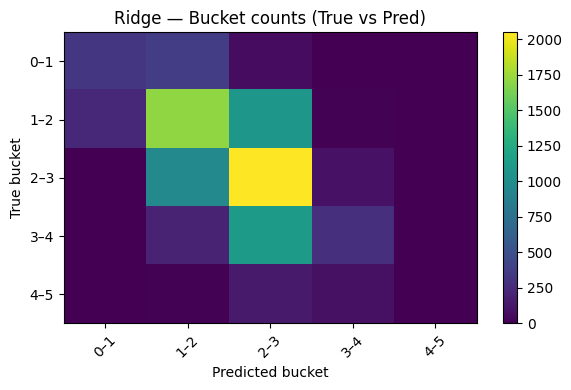

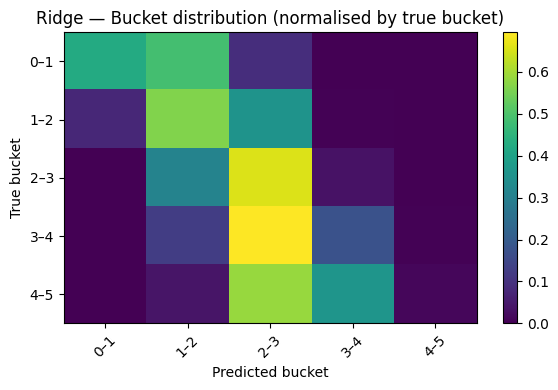

Saved LinearSVR count matrix -> /content/report_artifacts/LinearSVR_bucket_counts.csv
Saved LinearSVR normalized matrix -> /content/report_artifacts/LinearSVR_bucket_norm_by_true.csv


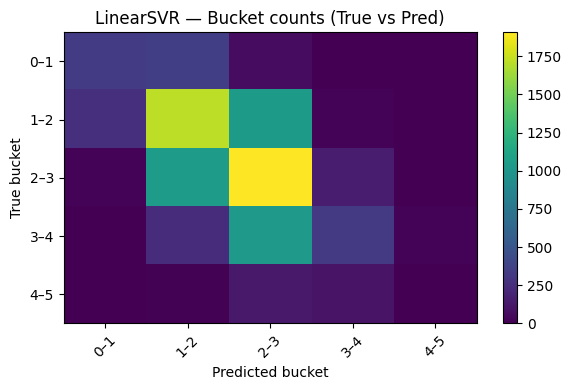

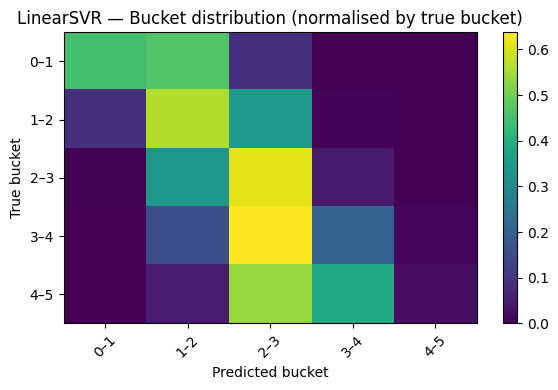

⚠️ No preds for RandomForest (expected files like RandomForest_foldN_predictions.csv). Skipping.

Done. Heatmaps and CSVs are saved in: /content/report_artifacts


In [8]:
# Bucket heatmaps (5 buckets) — paste & run in your Colab notebook
import os, glob
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

ART_DIR = "/content/report_artifacts"
if not os.path.exists(ART_DIR):
    raise FileNotFoundError(f"{ART_DIR} not found. Make sure your report artifacts folder exists (run earlier cells).")

models_to_check = ["Ridge", "LinearSVR", "RandomForest"]
buckets_labels = ["0–1","1–2","2–3","3–4","4–5"]

def load_preds_for_model(model_name):
    pattern = os.path.join(ART_DIR, f"{model_name}_fold*_predictions.csv")
    files = sorted(glob.glob(pattern))
    if not files:
        return None, []
    dfs = [pd.read_csv(f) for f in files]
    full = pd.concat(dfs, ignore_index=True)
    return full, files

def to_bucket(vals):
    a = np.array(vals, dtype=float)
    a = np.clip(a, 0.0, 4.9999)            # keep 5.0 mapped to last bucket
    buckets = np.floor(a).astype(int)     # 0..4
    return buckets

for model in models_to_check:
    df, files = load_preds_for_model(model)
    if df is None:
        print(f"⚠️ No preds for {model} (expected files like {model}_foldN_predictions.csv). Skipping.")
        continue

    if not {"y_true","y_pred"}.issubset(df.columns):
        # try lowercase names
        cols_lower = [c.lower() for c in df.columns]
        if "y_true" in cols_lower and "y_pred" in cols_lower:
            df.columns = [c.lower() for c in df.columns]
        else:
            print(f"⚠️ {model} prediction files missing y_true/y_pred columns. Found: {df.columns.tolist()}")
            continue

    true_b = to_bucket(df["y_true"].values)
    pred_b = to_bucket(df["y_pred"].values)

    mat = np.zeros((5,5), dtype=int)
    for t,p in zip(true_b, pred_b):
        mat[t,p] += 1

    # Row-normalise (distribution of predicted buckets given true bucket)
    row_sums = mat.sum(axis=1, keepdims=True)
    norm = np.divide(mat, row_sums, where=row_sums!=0).astype(float)

    # Save CSVs
    mat_df = pd.DataFrame(mat, index=buckets_labels, columns=buckets_labels)
    norm_df = pd.DataFrame(norm, index=buckets_labels, columns=buckets_labels)
    mat_path = os.path.join(ART_DIR, f"{model}_bucket_counts.csv")
    norm_path = os.path.join(ART_DIR, f"{model}_bucket_norm_by_true.csv")
    mat_df.to_csv(mat_path)
    norm_df.to_csv(norm_path)
    print(f"Saved {model} count matrix -> {mat_path}")
    print(f"Saved {model} normalized matrix -> {norm_path}")

    # Plot counts heatmap
    plt.figure(figsize=(6,4))
    plt.imshow(mat_df.values, aspect='auto')
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(buckets_labels)), labels=buckets_labels, rotation=45)
    plt.yticks(ticks=np.arange(len(buckets_labels)), labels=buckets_labels)
    plt.xlabel("Predicted bucket")
    plt.ylabel("True bucket")
    plt.title(f"{model} — Bucket counts (True vs Pred)")
    plt.tight_layout()
    png_counts = os.path.join(ART_DIR, f"{model}_bucket_counts.png")
    plt.savefig(png_counts, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

    # Plot normalised heatmap
    plt.figure(figsize=(6,4))
    plt.imshow(norm_df.values, aspect='auto')
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(buckets_labels)), labels=buckets_labels, rotation=45)
    plt.yticks(ticks=np.arange(len(buckets_labels)), labels=buckets_labels)
    plt.xlabel("Predicted bucket")
    plt.ylabel("True bucket")
    plt.title(f"{model} — Bucket distribution (normalised by true bucket)")
    plt.tight_layout()
    png_norm = os.path.join(ART_DIR, f"{model}_bucket_norm.png")
    plt.savefig(png_norm, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

print("\nDone. Heatmaps and CSVs are saved in:", ART_DIR)
